# 13. Frame Selected Stability

In [2]:
from src import *

/Users/michaelc.c.h/opt/miniconda3/envs/brain2/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Description

We look in this section for the stability of frame selected gradients across subjects (individual gradients approach) and also how stable the group gradients are when frame selecting compared to when full is used. 

GOAL: Evaluate differences of individual gradients of selected gradients and movie long gradients + evaluate differences of group gradients of selected timeseries and group gradients of full movies 

## Table of Contents
- [Frame selected emotion gradients](#comparison)

In [3]:
mri_path400 = "./data/fmri414_compiled/"

<a class="anchor" id="comparison"></a>
### Frame selected emotion gradients

Selecting snippets for timecourses according to emotion strength 

In [4]:
select = ['Anger','Guilt','WarmHeartedness', \
             'Disgust','Happiness','Fear','Regard','Anxiety', \
             'Satisfaction','Pride','Surprise','Love','Sad']

tmpdf = pd.read_csv('./data/emotion_compileBIDS.csv')

In [85]:
# Compute intensity metrics:
tmp_series = {}
for moviename in tmpdf.filename.unique():
    tmp_series[moviename] = []
    cur_series = tmpdf[tmpdf.filename==moviename]
    for idx,s in enumerate(select):
        distrib = list(cur_series[cur_series.item == s]['score'])
        if len(distrib) == 0: continue
        tmp_series[moviename].append(distrib)

# 1. Sum squares combining all emotions for each movie
intensity1_series = {}
for moviename in tmpdf.filename.unique():
    intensity1_series[moviename] = (np.asarray(tmp_series[moviename]) ** 2).sum(axis=0)
    
# 2. Averaging groups of emotions [detailed below] then sum squares combining
groups = [["Guilt", "Anger", "Disgust"], ["Sad"], ["Anxiety", "Fear", "Surprise"], ["Satisfaction", "Happiness", "Pride"], ["Love", "WarmHeartedness", "Regard"]]
groups_idx = np.asarray([[1, 0, 3], [12], [7, 5, 10], [8, 4, 9], [11, 2, 6]])
intensity2_series = {}
for moviename in tmpdf.filename.unique():
    tmp2_series = []
    # averaging per group (intermatiate mapping)
    for gidx in groups_idx:
        tmp2_series.append(np.asarray(tmp_series[moviename])[gidx].mean(axis=0))
    intensity2_series[moviename] = (np.asarray(tmp2_series) ** 2).sum(axis=0)

# 3. Averaging groups of positive emotions and negative emotions separately then sum squares combining both groups
groups = [["Guilt", "Anger", "Disgust", "Sad", "Anxiety", "Fear", "Surprise"], ["Satisfaction", "Happiness", "Pride", "Love", "WarmHeartedness", "Regard"]]
groups_idx = np.asarray([[1, 0, 3, 12, 7, 5, 10], [8, 4, 9, 11, 2, 6]])
intensity3_series = {}
for moviename in tmpdf.filename.unique():
    tmp2_series = []
    # averaging per group (intermatiate mapping)
    for gidx in groups_idx:
        tmp2_series.append(np.asarray(tmp_series[moviename])[gidx].mean(axis=0))
    intensity3_series[moviename] = (np.asarray(tmp2_series) ** 2).sum(axis=0)

/var/folders/95/vrc1ltz17tn5l8mk269kgjc80000gn/T/ipykernel_21944/3462044138.py:18: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  groups_idx = np.asarray([[1, 0, 3], [12], [7, 5, 10], [8, 4, 9], [11, 2, 6]])
/var/folders/95/vrc1ltz17tn5l8mk269kgjc80000gn/T/ipykernel_21944/3462044138.py:29: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  groups_idx = np.asarray([[1, 0, 3, 12, 7, 5, 10], [8, 4, 9, 11, 2, 6]])


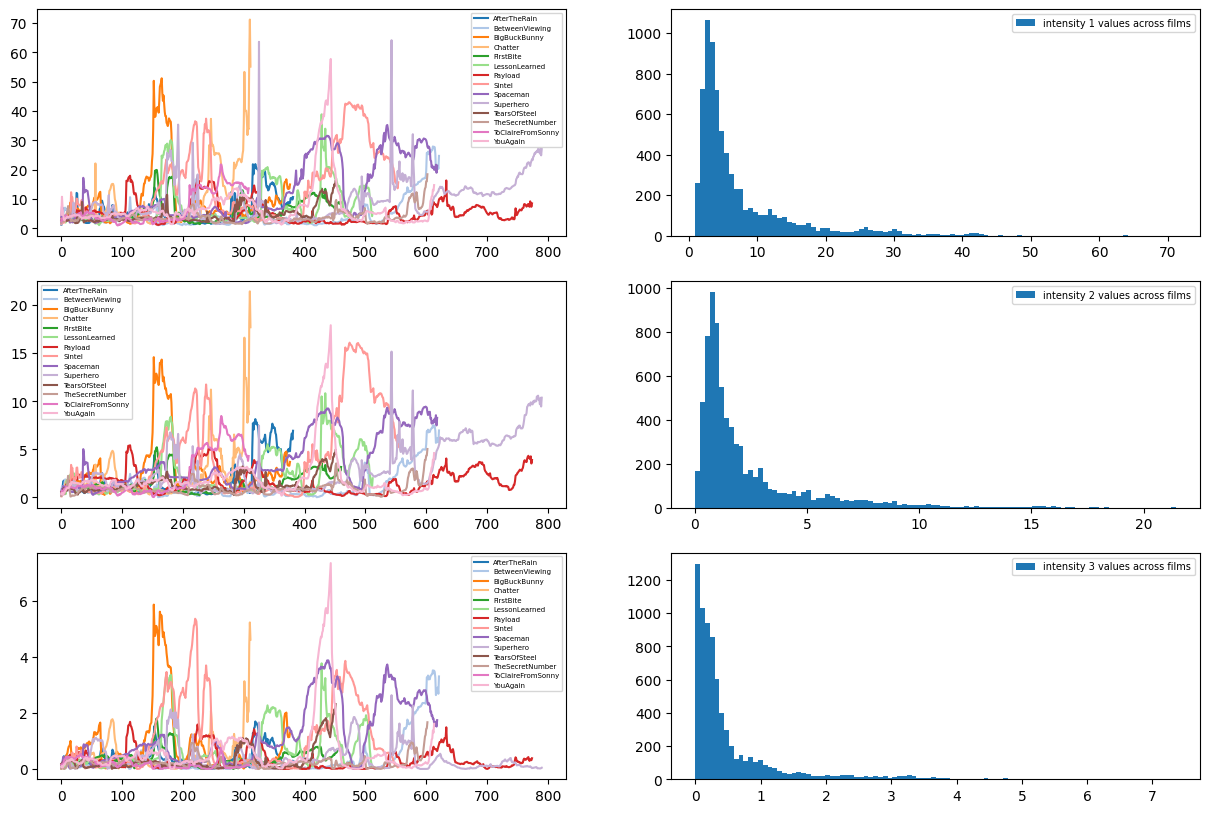

In [91]:
from matplotlib.colors import ListedColormap
intensity_scores = [intensity1_series, intensity2_series, intensity3_series]
# Displaying
pal     = sns.color_palette('tab20', len(tmpdf.filename.unique()))
my_cmap = ListedColormap(pal)
fig, ax = plt.subplots(3,2,figsize=(15,10))

# Scores
for k in range(3):
    for idx,moviename in enumerate(tmpdf.filename.unique()):
        ax[k,0].plot(intensity_scores[k][moviename], label=moviename[2:-6], color=my_cmap.colors[idx])
    ax[k,0].legend(prop={'size':5})

    distrib = np.concatenate(list(intensity_scores[k].values()))
    ax[k,1].hist(distrib, bins=100, label='intensity {} values across films'.format(k+1))
    ax[k,1].legend(prop={'size':7})


# threshold according for now: 80 percentile until 95 percentile 1 step at a time
thresholds = [[np.percentile(np.concatenate(list(intensity_scores[k].values())), 80+i) for i in range(16)] for k in range(3)]

Select frames (timecourses of fmri) according to the previously defined cutoff

In [100]:
# First find all timestamps/frames with a high enough intensity (high according to previous scoring scheme)

# FRAME SELECT ON EMOTIONS
for mnumb in range(3):
    for t in tqdm(range(len(thresholds[mnumb])-10)): # take only 80 percentile to 85
        selected_series = {m.split('_')[0]:[] for m in os.listdir(mri_path400)}
        for movie_name400 in tqdm(os.listdir(mri_path400)):
            if "Rest" in movie_name400: continue        
            mri_df400mov  = pd.read_csv(mri_path400 + movie_name400)
            mname         = movie_name400.split('_')[0]
            
            film_duration = FILM2DURATION[mname] # in seconds
            duration_film = int(film_duration/ TR) # in number of TRs
            front_pad     = int(WASH + ONSET) + 1

            # Simply replace 400 by 414 to look at spatial relation with subcortical regions included
            movies = [m for m in mri_df400mov.filename.unique() if "414" in m] 
            movie_series = []
            for m in movies:
                tmp1, _  = df_to_timeseries(mri_df400mov, m)
                tmp1     = tmp1[front_pad :  front_pad + duration_film]
                movie_series.append(tmp1)
            movie_series = np.asarray(movie_series)

            
            tmp = intensity_scores[mnumb]['W_{}13.csv'.format(mname)]
            tmp = tmp[:movie_series.shape[1]]

            # select from emotion timeseries frames with strong emotions
            frame_select = np.where(tmp   > thresholds[mnumb][t])[0]
            # append volume fmri corresponding to timestamp of intense positive emotion
            selected_series[mname] = movie_series[:,frame_select]
        
        save('./resources/threshes/tresh{}-{}.pkl'.format(80+t, mnumb), selected_series)

  0%|          | 0/6 [00:39<?, ?it/s]


KeyboardInterrupt: 

In [7]:
selected_series = load('./resources/threshes/thresh80.pkl')

In [8]:
# concatenate on different frames across movies
# basically doing reordering of columns
subject_tmpseries = [[] for _ in range(30)]
tmp = list(selected_series.values())
for i in range(len(tmp)):
    if len(tmp[i]) == 0: continue
    for nsub in range(30):
        subject_tmpseries[nsub].append(tmp[i][nsub])

subject_series = []
for i in range(30):
    subject_series.append(np.concatenate(subject_tmpseries[i]))

In [42]:
# Params
embedding  = "dm" # diffusion map
aff_kernel = "pearson" #affinity matrix kernel
align_meth = "procrustes"
n_iter     = 10 # procrustes align number of iteration
nb_comp    = 3
rs         = 99

# Compute individual gradients according to selected frames
subjects_gradients = []
for nsub in range(30):
    tmp_series = np.asarray(subject_series)[nsub]
    fc_selects  = FC(tmp_series)
    g_selects   = GradientMaps(n_components=nb_comp, approach=embedding, 
                        kernel=aff_kernel, random_state=rs)
    g_selects.fit(fc_selects)
    subjects_gradients.append(g_selects.gradients_)

# alignement across all gradients
select_subjects_gradients,_,s = procrustes_align(np.asarray(subjects_gradients))
select_subjects_gradients = np.asarray(select_subjects_gradients)

# Compute bootrstrap group gradients according to selected frames

Text(0.5, 0, 'std across 30 subjects')

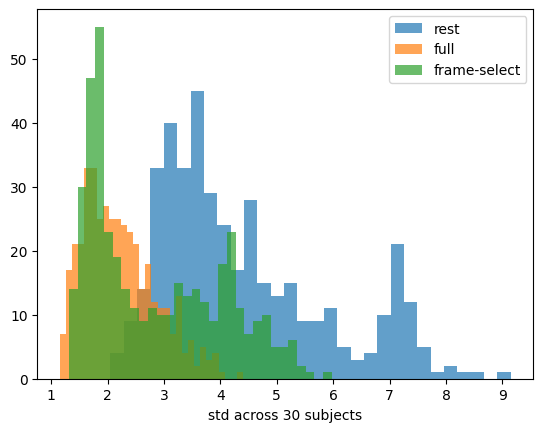

In [61]:
# Evaluate variance , first displaying macro levels distributions of variance as comparison side by side of static 

# REST INDIVIDUAL LOADING
rest_subjects_gradients = load('./resources/static_grad/individual_level/Rest_grad414.pkl')
rest_subjects_gradients = np.asarray(list(rest_subjects_gradients.values()))
rest_subjects_gradients,_,s = procrustes_align(np.asarray(rest_subjects_gradients))
rest_subjects_gradients = np.asarray(rest_subjects_gradients)

# FULL MOVIES LOADING
full_subjects_gradients = load('./resources/static_grad/individual_level/SUPERMOVIE_grad414.pkl')
full_subjects_gradients = np.asarray(list(full_subjects_gradients.values()))
full_subjects_gradients,_,s = procrustes_align(np.asarray(full_subjects_gradients))
full_subjects_gradients = np.asarray(full_subjects_gradients)

plt.hist(np.std(rest_subjects_gradients[:,:,0], axis=0), label='rest', bins=30, alpha=0.7)
plt.hist(np.std(full_subjects_gradients[:,:,0], axis=0), label='full', bins=30, alpha=0.7)
plt.hist(np.std(select_subjects_gradients[:,:,0], axis=0), label='frame-select', bins=30, alpha=0.7)

plt.legend()
plt.xlabel('std across 30 subjects')

In [ ]:
# Evaluate bootstrapped variance, first displaying macro levels distributions of variance as comparison side by side of static 

# REST INDIVIDUAL LOADING
rest_subjects_gradients = load('./resources/static_grad/individual_level/Rest_grad414.pkl')
rest_subjects_gradients = np.asarray(list(rest_subjects_gradients.values()))
rest_subjects_gradients,_,s = procrustes_align(np.asarray(rest_subjects_gradients))
rest_subjects_gradients = np.asarray(rest_subjects_gradients)

# FULL MOVIES LOADING
full_subjects_gradients = load('./resources/static_grad/individual_level/SUPERMOVIE_grad414.pkl')
full_subjects_gradients = np.asarray(list(full_subjects_gradients.values()))
full_subjects_gradients,_,s = procrustes_align(np.asarray(full_subjects_gradients))
full_subjects_gradients = np.asarray(full_subjects_gradients)

plt.hist(np.std(rest_subjects_gradients[:,:,0], axis=0), label='rest', bins=30, alpha=0.7)
plt.hist(np.std(full_subjects_gradients[:,:,0], axis=0), label='full', bins=30, alpha=0.7)
plt.hist(np.std(select_subjects_gradients[:,:,0], axis=0), label='frame-select', bins=30, alpha=0.7)

plt.legend()
plt.xlabel('std across 30 subjects')